## LLM Final Assessment
### Jason Clibanoff

In [4]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#word text libraries
from textblob import TextBlob
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize

#sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [5]:
#create and preview df
df = pd.read_csv("test(in).csv")
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


### 1. Sentiment Labeling

In [6]:
def categorize_sentiment(subject, body):
    #extract sentiment from both the subject and body using textblobs
    subject_sentiment = TextBlob(subject).sentiment.polarity
    body_sentiment = TextBlob(body).sentiment.polarity    
    avg_sentiment = (subject_sentiment + body_sentiment) / 2 
    
    if avg_sentiment > 0:
        return "Positive"
    elif avg_sentiment < 0:
        return "Negative"
    else:
        return "Neutral"

In [7]:
df["sentiment"] = df.apply(lambda row: categorize_sentiment(row['Subject'], row['body']), axis = 1)
df.head()

,Subject,body,date,from,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,Positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,Positive
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,Negative
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Negative


### 2. Exploratory Data Analysis

In [8]:
df.shape

(2191, 5)

In [9]:
df.describe()

,Subject,body,date,from,sentiment
count,2191,2191,2191,2191,2191
unique,1251,1539,690,10,3
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com,Positive
freq,141,21,9,284,1330


In [10]:
df.dtypes

Subject      object
body         object
date         object
from         object
sentiment    object
dtype: object

In [11]:
#convert date to datetime
df['date'] = pd.to_datetime(df['date'], format = '%m/%d/%Y')
print(df.dtypes)
df.head()

Subject              object
body                 object
date         datetime64[ns]
from                 object
sentiment            object
dtype: object


,Subject,body,date,from,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative


In [56]:
df['sentiment'].value_counts()

sentiment
Positive    1330
Neutral      547
Negative     314
Name: count, dtype: int64

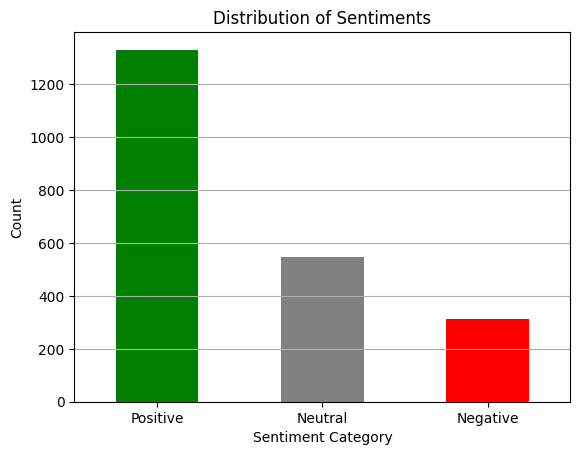

In [12]:
#count occurrences of each sentiment category
sentiment_counts = df['sentiment'].value_counts()

#plot bar graph
plt.figure()
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Distribution of Sentiments")
plt.xticks(rotation=0)
plt.grid(axis='y')

#show/save the plot
plt.savefig('Distribution of Sentiments.png')
plt.show()

In [13]:
sentiments_gb = df.groupby(['from', 'sentiment']).size().reset_index(name='count')


In [14]:
sentiments_pivot = sentiments_gb.pivot(index='from', columns='sentiment', values='count').fillna(0)
sentiments_pivot

sentiment,Negative,Neutral,Positive
from,,,
bobette.riner@ipgdirect.com,33,53,131
don.baughman@enron.com,24,66,123
eric.bass@enron.com,34,45,131
john.arnold@enron.com,30,69,157
johnny.palmer@enron.com,31,46,136
kayne.coulter@enron.com,25,37,112
lydia.delgado@enron.com,45,75,164
patti.thompson@enron.com,32,55,138
rhonda.denton@enron.com,30,47,95


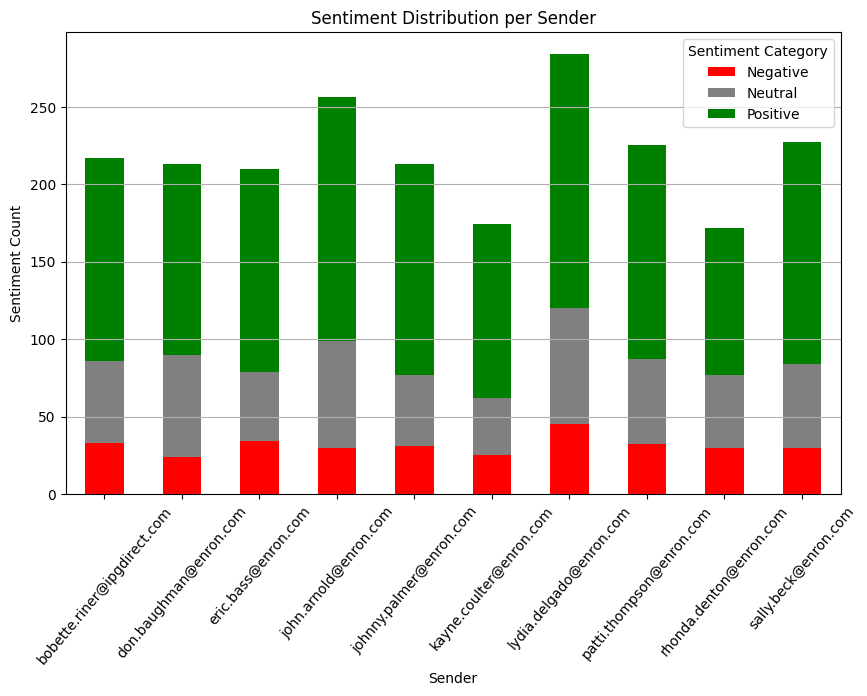

In [15]:
sentiments_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'})
plt.xlabel("Sender")
plt.ylabel("Sentiment Count")
plt.title("Sentiment Distribution per Sender")
plt.xticks(rotation = 50)
plt.legend(title = "Sentiment Category")
plt.grid(axis='y')
plt.savefig("Sentiment Distribution per Sender.png")

In [16]:
#function to give a sentiment score to each entry
def get_sentiment_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0     
df['sentiment score'] = df.apply(lambda row: get_sentiment_score(row['sentiment']), axis = 1)
df.head()

,Subject,body,date,from,sentiment,sentiment score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,-1
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative,-1


In [17]:
#group by month, from(email address), and sentiment, then make pivot table with montha sindex for easy access to monthly data
monthly_sentiments = df.groupby([df['date'].dt.to_period('M'), 'from', 'sentiment']).size().reset_index(name='count')

monthly_pivot = monthly_sentiments.pivot(index=['date', 'from'], columns='sentiment', values='count').fillna(0)
monthly_pivot

sentiment                            Negative  Neutral  Positive
date    from                                                    
2010-01 bobette.riner@ipgdirect.com       0.0      0.0       2.0
        don.baughman@enron.com            0.0      3.0       6.0
        eric.bass@enron.com               1.0      2.0       7.0
        john.arnold@enron.com             1.0      2.0       4.0
        johnny.palmer@enron.com           1.0      1.0       4.0
...                                       ...      ...       ...
2011-12 kayne.coulter@enron.com           1.0      1.0       7.0
        lydia.delgado@enron.com           6.0      2.0       9.0
        patti.thompson@enron.com          2.0      2.0       8.0
        rhonda.denton@enron.com           1.0      3.0       7.0
        sally.beck@enron.com              0.0      5.0       4.0

[240 rows x 3 columns]

In [18]:
monthly_sentiments.head()

,date,from,sentiment,count
0,2010-01,bobette.riner@ipgdirect.com,Positive,2
1,2010-01,don.baughman@enron.com,Neutral,3
2,2010-01,don.baughman@enron.com,Positive,6
3,2010-01,eric.bass@enron.com,Negative,1
4,2010-01,eric.bass@enron.com,Neutral,2


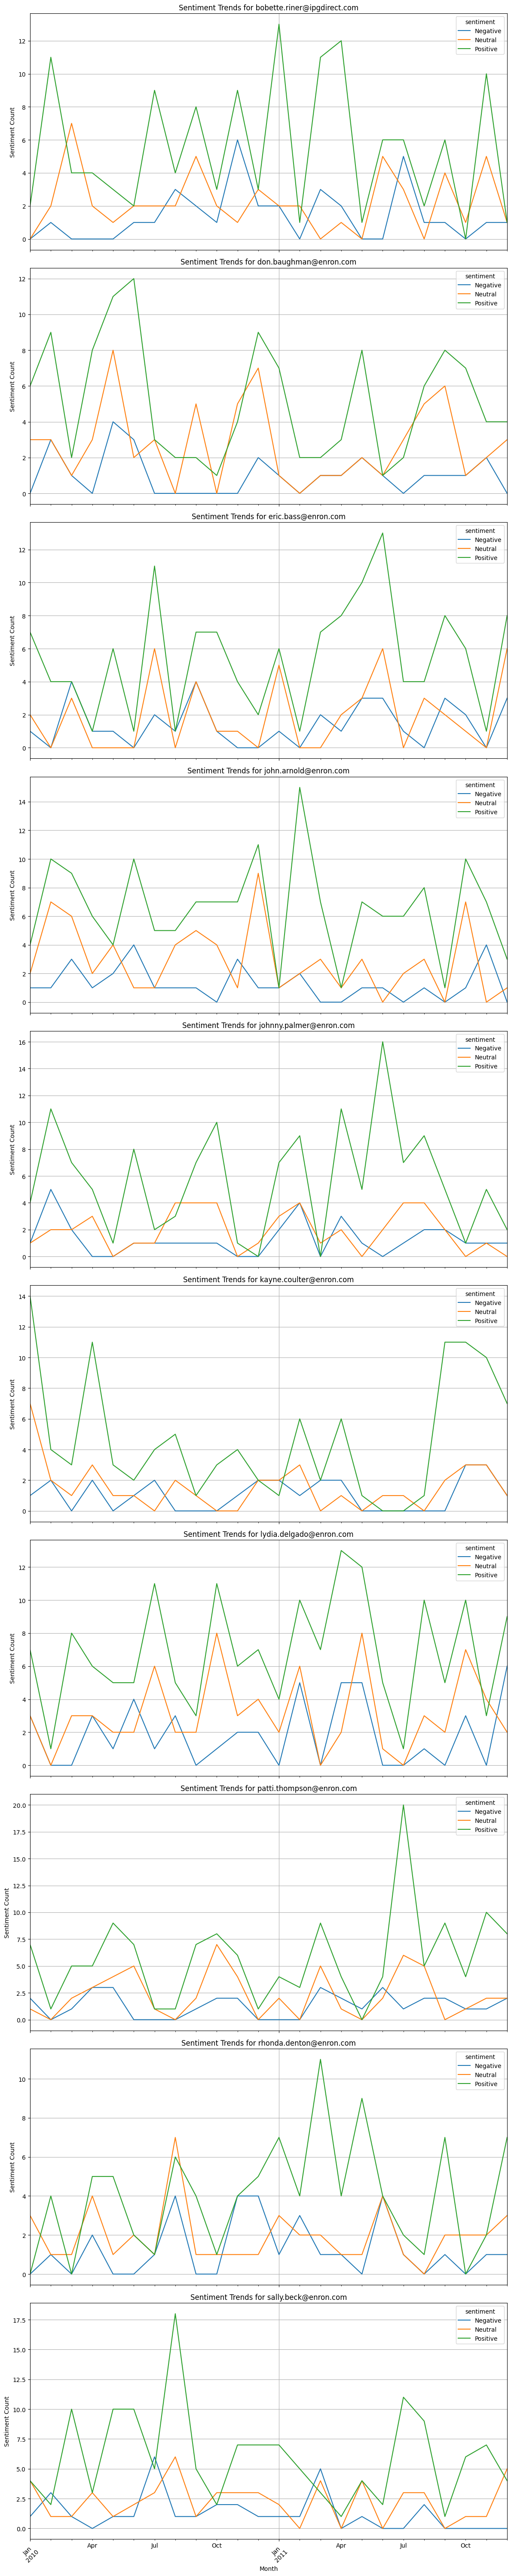

In [19]:
#plot sentiment trends for each email address
senders = monthly_pivot.index.get_level_values('from').unique()
fig, axes = plt.subplots(len(senders), 1, figsize=(12, 6 * len(senders)), sharex=True)

for ax, sender in zip(axes, senders):
    monthly_pivot.xs(sender, level='from').plot(kind='line', linestyle='-', ax=ax)
    ax.set_title(f"Sentiment Trends for {sender}")
    ax.set_ylabel("Sentiment Count")
    ax.grid(True)

#set labels
plt.xlabel("Month")
plt.xticks(rotation=45)

#display
plt.tight_layout()
plt.show()


### 3. Calculate Sentiment Scores

In [20]:
#function to give a sentiment score to each entry
def get_sentiment_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0     


In [21]:
df['sentiment score'] = df.apply(lambda row: get_sentiment_score(row['sentiment']), axis = 1)
df.head()

,Subject,body,date,from,sentiment,sentiment score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,-1
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative,-1


In [22]:
#to calculate the score for each month, I use a pivot table where the month is the index, 
#and add 1 for positive and -1 for negative, ignoring neutral because it adds 0 points. 
monthly_pivot['Monthly Sentiment Score'] = (monthly_pivot['Positive'] * 1 + monthly_pivot['Negative'] * -1)
monthly_pivot                                 

sentiment                            Negative  Neutral  Positive  \
date    from                                                       
2010-01 bobette.riner@ipgdirect.com       0.0      0.0       2.0   
        don.baughman@enron.com            0.0      3.0       6.0   
        eric.bass@enron.com               1.0      2.0       7.0   
        john.arnold@enron.com             1.0      2.0       4.0   
        johnny.palmer@enron.com           1.0      1.0       4.0   
...                                       ...      ...       ...   
2011-12 kayne.coulter@enron.com           1.0      1.0       7.0   
        lydia.delgado@enron.com           6.0      2.0       9.0   
        patti.thompson@enron.com          2.0      2.0       8.0   
        rhonda.denton@enron.com           1.0      3.0       7.0   
        sally.beck@enron.com              0.0      5.0       4.0   

sentiment                            Monthly Sentiment Score  
date    from                                                  
2010-01 bobette.riner@ipgdirect.com                      2.0  
        don.baughman@enron.com                           6.0  
        eric.bass@enron.com                              6.0  
        john.arnold@enron.com                            3.0  
        johnny.palmer@enron.com                          3.0  
...                                                      ...  
2011-12 kayne.coulter@enron.com                          6.0  
        lydia.delgado@enron.com                          3.0  
        patti.thompson@enron.com                         6.0  
        rhonda.denton@enron.com                          6.0  
        sally.beck@enron.com                             4.0  

[240 rows x 4 columns]

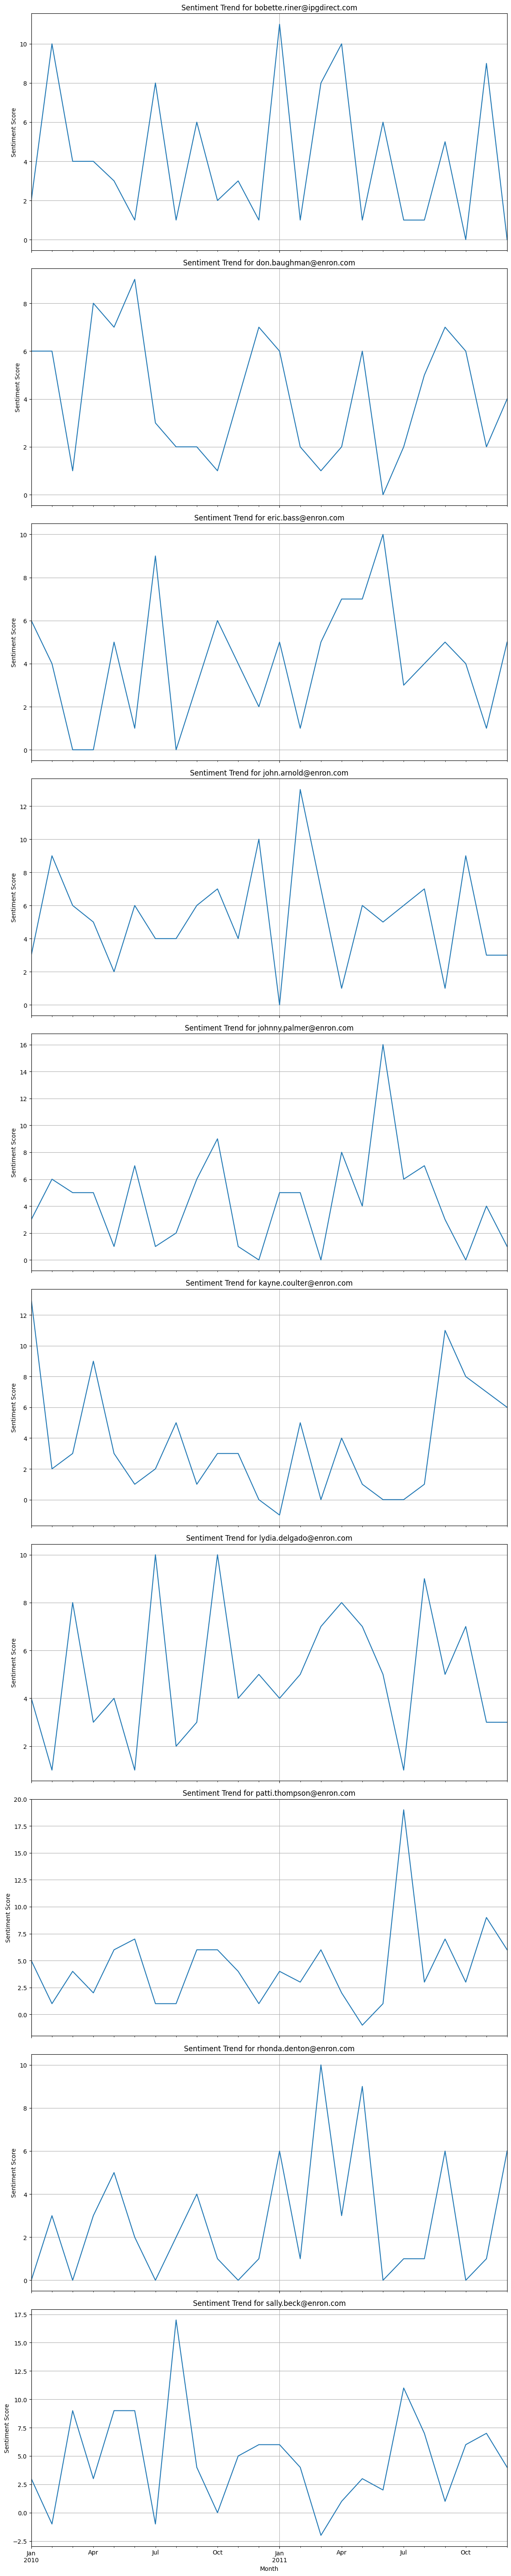

In [23]:
#make plots of each employee's monthly sentiment scores over time
fig, axes = plt.subplots(len(senders), 1, figsize=(12, 6 * len(senders)), sharex=True)

for ax, sender in zip(axes, senders):
    monthly_pivot.xs(sender, level='from')['Monthly Sentiment Score'].plot(linestyle='-', ax = ax)
    ax.set_title(f"Sentiment Trend for {sender}")
    ax.set_ylabel("Sentiment Score")
    ax.grid(True)

plt.xlabel("Month")

#display plots
plt.tight_layout()
plt.show()

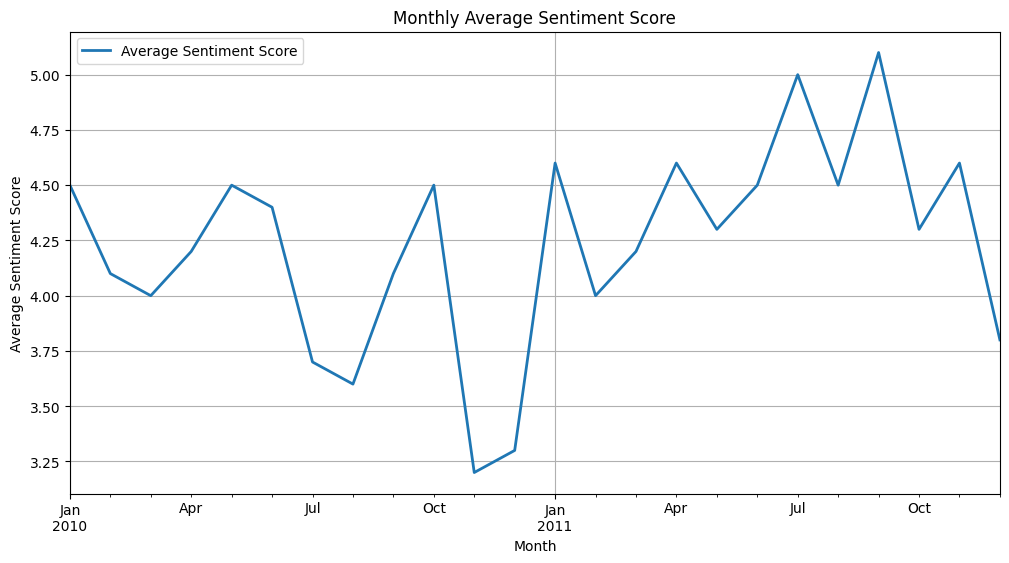

In [24]:
#monthly average sentiment across all employees
monthly_avg = monthly_pivot.groupby(level='date')['Monthly Sentiment Score'].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot(linestyle='-', linewidth=2, label="Average Sentiment Score")

plt.title("Monthly Average Sentiment Score")
plt.xlabel("Month")
plt.ylabel("Average Sentiment Score")
plt.grid(True)
plt.legend()
plt.savefig("Monthly Average Sentiment Score.png")
plt.show()


### 4. Employee Ranking

In [25]:
#find who has the highest and lowest all time sentiment scores
sentiments_pivot['total sentiment score'] = (sentiments_pivot['Positive'] * 1 + sentiments_pivot['Negative'] * -1)
pos_sentiments_pivot = sentiments_pivot.sort_values(by='total sentiment score', ascending = False)
neg_sentiments_pivot = sentiments_pivot.sort_values(by='total sentiment score', ascending = True)

#print top 3 most positive and negative all time
print('Highest Sentiment Score')
display(pos_sentiments_pivot.head(3))
print('Lowest Sentiment Score')
display(neg_sentiments_pivot.head(3))

Highest Sentiment Score


sentiment,Negative,Neutral,Positive,total sentiment score
from,,,,
john.arnold@enron.com,30,69,157,127
lydia.delgado@enron.com,45,75,164,119
sally.beck@enron.com,30,54,143,113


Lowest Sentiment Score


sentiment,Negative,Neutral,Positive,total sentiment score
from,,,,
rhonda.denton@enron.com,30,47,95,65
kayne.coulter@enron.com,25,37,112,87
eric.bass@enron.com,34,45,131,97


In [26]:
#A funtion to find the highest, and a function to find the lowest sentiment scores for a given month
def top_3_scores(month):
    #access monthly data from the monthly pivot table
    monthly_data = monthly_pivot.xs(month, level='date')
    #get the top 3 for the selected month, sorted by score and alphabetically
    top_3 = monthly_data.sort_values(by=['Monthly Sentiment Score', 'from'], ascending=[False, True]).head(3)
    #put the top 3 emails and scores in a list
    top_3_list = top_3.reset_index()[['from', 'Monthly Sentiment Score']].values.tolist()
    #put the data from the new list into a data frame for readable output
    new_col_name = f'Highest Sentiment Scores ({month})' 
    top_3_df = pd.DataFrame(top_3_list, columns = ['Email Address', new_col_name])
    #I adjust the index so it reflects the ranking
    top_3_df.index = range(1, len(top_3_df) + 1)
    #return the df
    return top_3_df

#and the same for bottom 3
def bottom_3_scores(month):
    monthly_data = monthly_pivot.xs(month, level='date')
    bottom_3 =  monthly_data.sort_values(by=['Monthly Sentiment Score', 'from'], ascending=[True, True]).head(3)
    bottom_3_list = bottom_3.reset_index()[['from', 'Monthly Sentiment Score']].values.tolist()
    new_col_name = f'Lowest Sentiment Scores ({month})'
    bottom_3_df = pd.DataFrame(bottom_3_list, columns=['Email Address', new_col_name])
    bottom_3_df.index = range(1, len(bottom_3_df) + 1)
    return bottom_3_df

In [27]:
#example
example_month = '2010-07'
top_senders_2010_06 = top_3_scores(example_month)
bottom_senders_2010_06 = bottom_3_scores(example_month)

print("Most Positive Employees")
display(top_senders_2010_06)
print("Most Negative Employees")
display(bottom_senders_2010_06)

Most Positive Employees


,Email Address,Highest Sentiment Scores (2010-07)
1,lydia.delgado@enron.com,10.0
2,eric.bass@enron.com,9.0
3,bobette.riner@ipgdirect.com,8.0


Most Negative Employees


,Email Address,Lowest Sentiment Scores (2010-07)
1,sally.beck@enron.com,-1.0
2,rhonda.denton@enron.com,0.0
3,johnny.palmer@enron.com,1.0


### 5. Flight Risk Identification

In [28]:
#filter for negative sentiment
neg_df = df[df['sentiment score'] == -1].copy()
#sort by sender and date
neg_df = neg_df.sort_values(['from', 'date'])
#make enpty list to hold info
flight_risk = []
#loop to process each sender individually
for sender, group in neg_df.groupby('from'):
    group = group.copy()    
    #ensure datetime index and sorted
    group = group.set_index('date').sort_index()    
    #add rolling 30 day window on sentiment entries
    group['count_30d'] = (
        group['sentiment score']
        .rolling('30D')
        .count())
    #restore 'date' to a column
    group = group.reset_index()    
    flight_risk.append(group)

#combine all sender groups into one df
rolling_df = pd.concat(flight_risk)
#find suspicious senders with at least 4 negatives in any 30-day window
suspicious_senders = rolling_df[rolling_df['count_30d'] >= 4]['from'].unique()

print("Suspicious senders (>=4 negative messages in any 30-day period):")
print(suspicious_senders)


Suspicious senders (>=4 negative messages in any 30-day period):
['bobette.riner@ipgdirect.com' 'don.baughman@enron.com'
 'eric.bass@enron.com' 'john.arnold@enron.com' 'johnny.palmer@enron.com'
 'lydia.delgado@enron.com' 'patti.thompson@enron.com'
 'rhonda.denton@enron.com' 'sally.beck@enron.com']


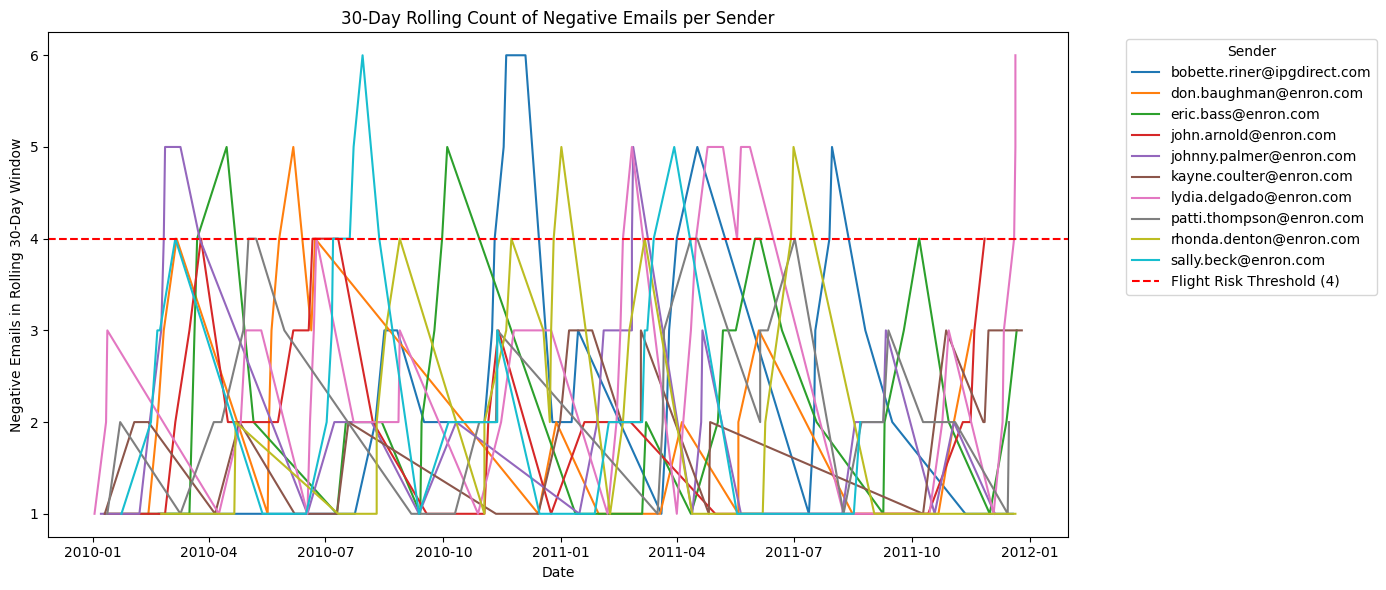

In [29]:
#plot rolling 30 days vs count of negative emails
plt.figure(figsize=(14, 6))
for sender, group in rolling_df.groupby('from'):
    plt.plot(group['date'], group['count_30d'], label=sender)

#show threshold
plt.axhline(4, color='red', linestyle='--', label='Flight Risk Threshold (4)')

#formatting
plt.title('30-Day Rolling Count of Negative Emails per Sender')
plt.xlabel('Date')
plt.ylabel('Negative Emails in Rolling 30-Day Window')
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('flight risk threshold.png')
plt.show()

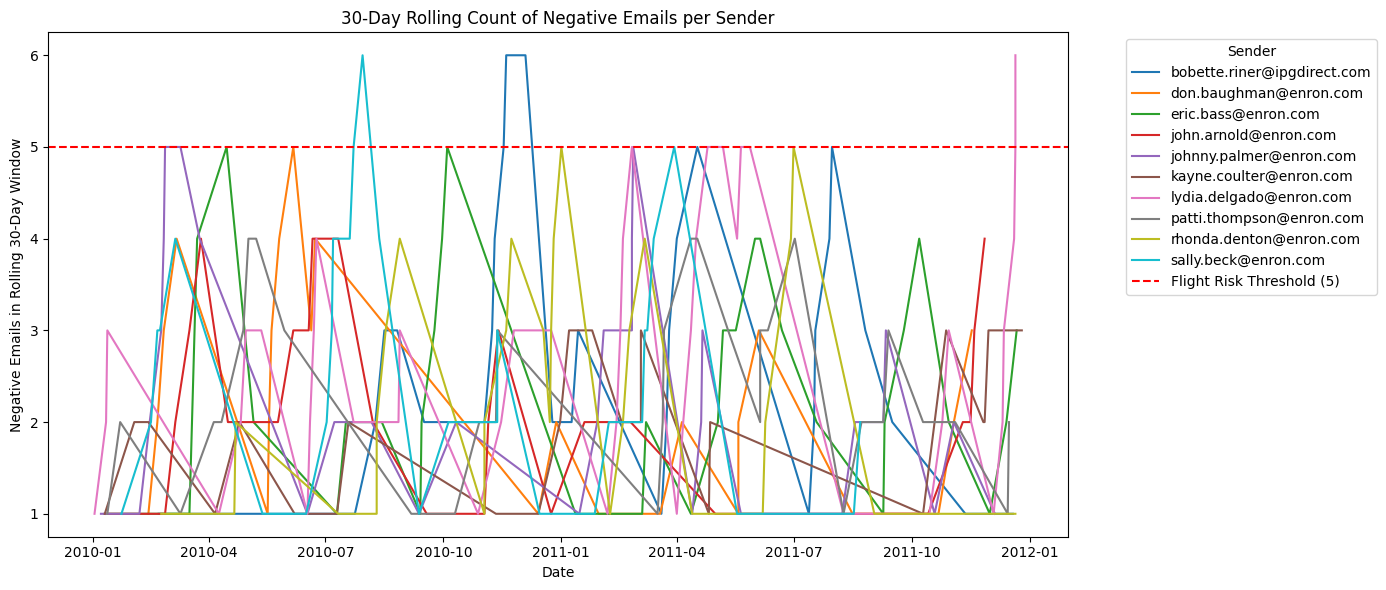

In [30]:
#maybe check a higher threshold to narrow things down a bit
#plot rolling 30 days vs count of negative emails
plt.figure(figsize=(14, 6))
for sender, group in rolling_df.groupby('from'):
    plt.plot(group['date'], group['count_30d'], label=sender)

#show threshold
plt.axhline(5, color='red', linestyle='--', label='Flight Risk Threshold (5)')

#formatting
plt.title('30-Day Rolling Count of Negative Emails per Sender')
plt.xlabel('Date')
plt.ylabel('Negative Emails in Rolling 30-Day Window')
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('increased flight risk threshold.png')
plt.show()

### 6. Predictive Modelling

Feature Engineering:

In [31]:
df.head()

,Subject,body,date,from,sentiment,sentiment score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,-1
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative,-1


In [32]:
#load positive and negative word lists
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [33]:
def sentiment_word_percentage(text):
    #tokenize & lowercase text
    words = word_tokenize(text.lower())  
    total_words = len(words)
    
    #count positive & negative words
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    
    #get percentages
    pos_percentage = (pos_count / total_words) * 100 if total_words > 0 else 0
    neg_percentage = (neg_count / total_words) * 100 if total_words > 0 else 0

    return pos_percentage, neg_percentage, pos_count, neg_count, total_words

In [34]:
# Apply function to 'Subject' and 'Body' separately
df[['subject_pos_pct', 'subject_neg_pct', 'subject_pos_count', 'subject_neg_count', 'subject_total_words']] = df['Subject'].apply(sentiment_word_percentage).apply(pd.Series)
df[['body_pos_pct', 'body_neg_pct', 'body_pos_count', 'body_neg_count', 'body_total_words']] = df['body'].apply(sentiment_word_percentage).apply(pd.Series)

# Check updated DataFrame
df.head(3)

,Subject,body,date,from,sentiment,sentiment score,subject_pos_pct,subject_neg_pct,subject_pos_count,subject_neg_count,subject_total_words,body_pos_pct,body_neg_pct,body_pos_count,body_neg_count,body_total_words
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,1,0.0,0.0,0.0,0.0,3.0,0.877193,0.000000,1.0,0.0,114.0
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Positive,1,0.0,0.0,0.0,0.0,4.0,3.030303,1.515152,2.0,1.0,66.0
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,0,0.0,0.0,0.0,0.0,7.0,0.000000,0.000000,0.0,0.0,50.0


In [55]:
monthly_df = df.groupby([df['date'].dt.to_period('M'), 'from']).agg({
    'sentiment score': 'sum',        #total sentiment score
    'subject_pos_pct': 'mean',       #avg positive word percentage in subject
    'subject_neg_pct': 'mean',       #avg negative word percentage in subject
    'subject_pos_count': 'sum',      #total positive words in subject
    'subject_neg_count': 'sum',      #total negative words in subject
    'subject_total_words': 'sum',    #total words in subject
    'body_pos_pct': 'mean',          #avg positive word percentage in body
    'body_neg_pct': 'mean',          #avg negative word percentage in body
    'body_pos_count': 'sum',         #total positive words in body
    'body_neg_count': 'sum',         #total negative words in body
    'body_total_words': 'sum'        #total words in body
}).reset_index()
#add message count per sender per month
monthly_df['message_count'] = df.groupby([df['date'].dt.to_period('M'), 'from']).size().values

monthly_df.head(3)

,date,from,sentiment score,subject_pos_pct,subject_neg_pct,subject_pos_count,subject_neg_count,subject_total_words,body_pos_pct,body_neg_pct,body_pos_count,body_neg_count,body_total_words,message_count
0,2010-01,bobette.riner@ipgdirect.com,2,0.000000,0.0,0.0,0.0,12.0,1.785714,0.000000,1.0,0.0,39.0,2
1,2010-01,don.baughman@enron.com,6,2.777778,0.0,1.0,0.0,32.0,3.632712,0.127714,9.0,1.0,364.0,9
2,2010-01,eric.bass@enron.com,6,0.000000,0.0,0.0,0.0,50.0,2.936861,0.524476,12.0,3.0,444.0,10


In [46]:
#sort by date to ensure correct ordering
monthly_df = monthly_df.sort_values(by='date')
#create a numeric index for months starting at 1, and drop original date column
monthly_df['month_index'] = monthly_df['date'].astype(str).astype('datetime64[ns]').dt.to_period('M').factorize()[0] + 1
#drop non-numeric columns, date has been replaced. 'from' is being dropped to prevent data leakage
monthly_df.drop(columns =['date', 'from'], inplace = True)
monthly_df = monthly_df.rename(columns={'sentiment score': 'monthly sentiment score'})

monthly_df.head(1)

,monthly sentiment score,subject_total_words,body_pos_pct,body_neg_pct,body_pos_count,body_neg_count,body_total_words,message_count,month_index
0,2,12.0,1.785714,0.0,1.0,0.0,39.0,2,1


Train Test Split

In [47]:
X = monthly_df.drop(columns=['monthly sentiment score'])
y = monthly_df['monthly sentiment score']

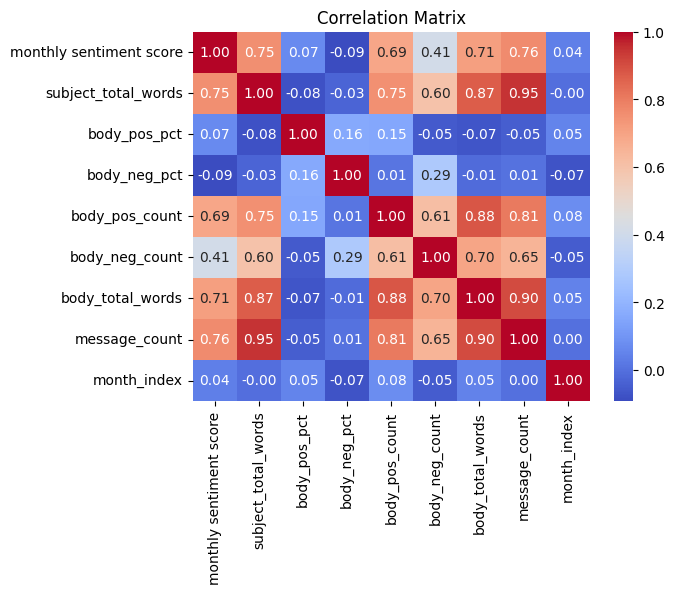

In [48]:
corr_matrix = monthly_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig('correlation_matrix.png')
plt.show()

In [49]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create the model and make predictions

In [51]:
#create linear regression model
model = LinearRegression()

#fit the model to the training data. 
model.fit(X_train_scaled, y_train)

LinearRegression()

In [52]:
#use model to make predictions
predictions = model.predict(X_test_scaled)

In [53]:
#evaluate model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


Mean Squared Error (MSE): 4.5650
R2 Score: 0.5349


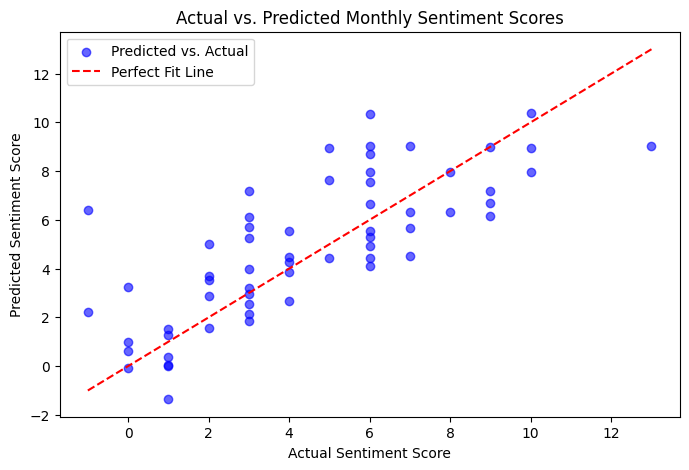

In [54]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, predictions, color='blue', alpha=0.6, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', label='Perfect Fit Line')

# Labels & Titles
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs. Predicted Monthly Sentiment Scores")
plt.legend()
plt.savefig("Actual vs. Predicted Monthly Sentiment Scores.png")
plt.show()